In [55]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")


Shape: (45211, 19)


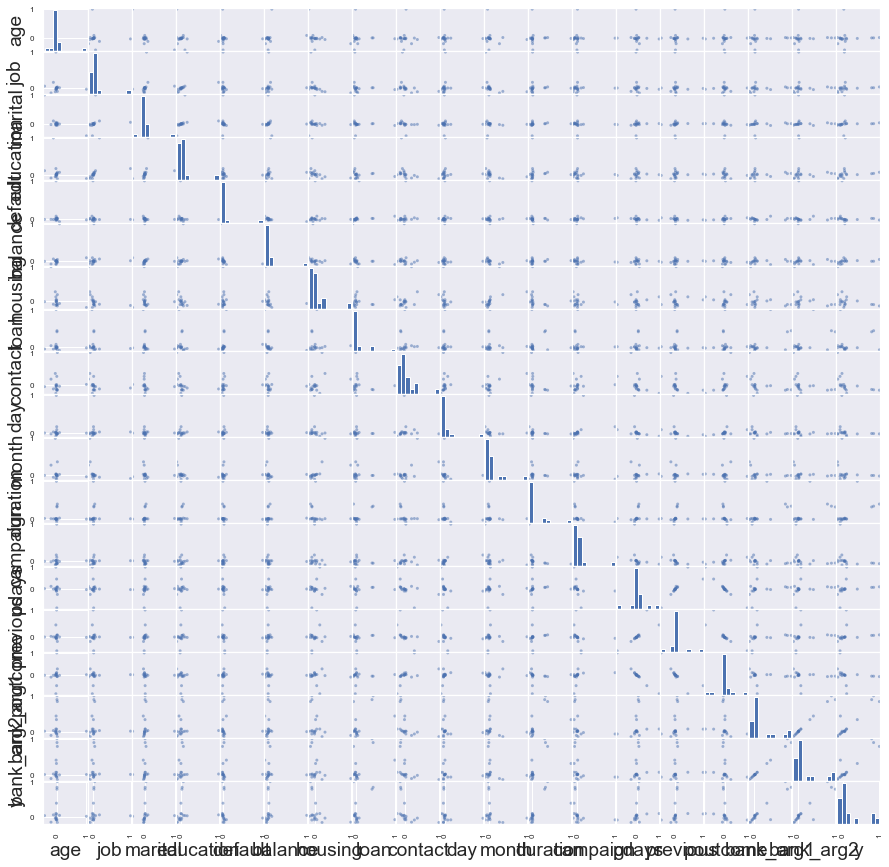

In [56]:
raw_dataset = read_csv(r'bank.csv')
dataset = read_csv(r'bank.csv')

# Pre-processing dataset
le_en = preprocessing.LabelEncoder()
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']:
    dataset[col] = dataset[col].astype('category')
    dataset[col] = le_en.fit_transform(dataset[col])
# print(dataset.dtypes)
# print(dataset.head())

dataset.head(2)
raw_dataset.head(2)

print(f"Shape: {dataset.shape}")

scatter_matrix(dataset.corr(), figsize=(15,15))
plt.show()


## 1. Create two data-sets as follows:

  * (a) **Dataset 1**: age,job,poutcome, balance, default and y, where y is the class attribute.

  * (b) **Dataset 2**: age,job,poutcome, balance, default and loan, where loan is the class attribute.

### Apply a classification algorithm on each dataset and report the error. Which dataset has a higher accuracy (lower error)? Note, all the data should be used for training the model from both datasets.

In [57]:
def test_accuracy(ds):
    array = ds.values
    # 6th column (index 5) is 'y' for Dataset 1, 'loan' for Dataset 2
    X = array[:,0:5]
    Y = array[:,5]
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=1, random_state=1)

    # Tested all these algorithms. LogisticRegression (LR) resulted in the highest accuracy.
    #   LR: Accuracy: 0.882714 - Error: 0.117286 (Std Dev: 0.000201)
    #   LDA: Accuracy: 0.882438 - Error: 0.117562 (Std Dev: 0.000389)
    #   KNN: Accuracy: 0.869857 - Error: 0.130143 (Std Dev: 0.002554)
    #   CART: Accuracy: 0.818735 - Error: 0.181265 (Std Dev: 0.007136)
    #   NB: Accuracy: 0.870327 - Error: 0.129673 (Std Dev: 0.001553)

    model = ('LR', LogisticRegression(solver='liblinear', multi_class='ovr'))
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model[1], X_train, Y_train, cv=kfold, scoring='accuracy')
    print('%s: Accuracy: %f - Error: %f (Std Dev: %f)' % (model[0], cv_results.mean(), (1 - cv_results.mean()), cv_results.std()))
    return 1 - cv_results.mean()


# Dataset 1
dataset_1 = dataset[['age','job','poutcome','balance','default', 'y']]
print("\n💽 Dataset 1:")
error_1 = test_accuracy(dataset_1)

# Dataset 2
dataset_2 = dataset[['age','job','poutcome','balance','default', 'loan']]
print("\n💽 Dataset 2:")
error_2 = test_accuracy(dataset_2)

print("\n🔎 Dataset 1" if error_1 < error_2 else "Dataset 2", "has higher accuracy (lower error)")




💽 Dataset 1:
LR: Accuracy: 0.882924 - Error: 0.117076 (Std Dev: 0.000173)

💽 Dataset 2:
LR: Accuracy: 0.839792 - Error: 0.160208 (Std Dev: 0.000142)

🔎 Dataset 1 has higher accuracy (lower error)


### 2. Create a dataset by using: _age_ and **marital**. Apply an unsupervised learning algorithm and cluster all the individuals in the dataset. Determine the optimal number of clusters/groups for your dataset using an appropriate visualization technique.



🎯 Data points and distances to clusters centers:
     Object  X_value  Y_value  C1_Distance  C2_Distance  C3_Distance  Cluster
0  Object 1        1       58     8.000000     8.062258     8.062258  Married
1  Object 2        2       44     6.082763     6.000000     6.324555   Single
2  Object 3        1       33    17.000000    17.029386    17.029386  Married
3  Object 4        1       47     3.000000     3.162278     3.162278  Married
4  Object 5        2       33    17.029386    17.000000    17.117243   Single

🎯 Centroid 1 (Married) (1.0, 43.40809877269053)
🎯 Centroid 2 (Single) (2.0, 33.7034401876466)
🎯 Centroid 3 (Divorced) (0.0, 45.78298444401767)


🎯 Centroids after model fit:
[[31.67274242  1.41756088]
 [56.4044536   0.87659407]
 [43.08399507  1.02183735]]


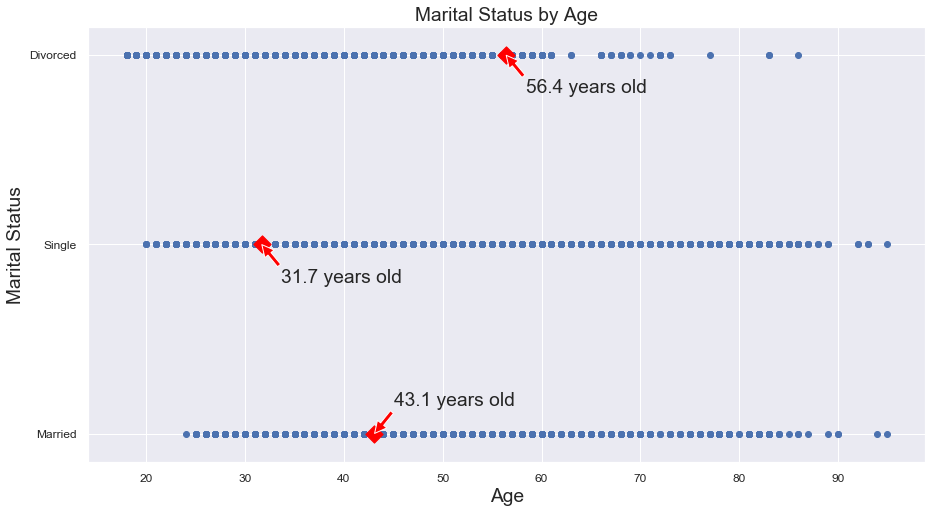

In [58]:

# am = raw_dataset[['age','marital']]
am = dataset[['age','marital']]

plt.figure(figsize=(15, 8))


# Generate object header for the data points
obj_names = []
for i in range(1, len(am)+1):
    obj = "Object " + str(i)
    obj_names.append(obj)

# Create a pandas DataFrame with the names and (x, y) coordinates
data = pd.DataFrame({
    'Object': obj_names,
    'X_value': am['marital'],
    'Y_value': am['age']
})    

# print(data.head())

# 0 - divorced
# 1 - married
# 2 - single

marital_status = am['marital'].unique()
marital_status_str = [s.title() for s in raw_dataset['marital'].unique()] 

# Initialize the centroids
c1 = (marital_status[0], 50)
c2 = (marital_status[1], 50)
c3 = (marital_status[2], 50)

def calculate_distance(centroid, X, Y):
    distances = []
        
    # Unpack the x and y coordinates of the centroid
    c_x, c_y = centroid
        
    # Iterate over the data points and calculate the distance 
    for x, y in list(zip(X, Y)):
        root_diff_x = (x - c_x) ** 2
        root_diff_y = (y - c_y) ** 2
        distance = np.sqrt(root_diff_x + root_diff_y)
        distances.append(distance)
        
    return distances

# Calculate the distance and assign them to the DataFrame accordingly
data['C1_Distance'] = calculate_distance(c1, data.X_value, data.Y_value)
data['C2_Distance'] = calculate_distance(c2, data.X_value, data.Y_value)
data['C3_Distance'] = calculate_distance(c3, data.X_value, data.Y_value)

# Get the minimum distance centroids
data['Cluster'] = data[['C1_Distance', 'C2_Distance', 'C3_Distance']].apply(np.argmin, axis =1)
    
# Map the centroids accordingly and rename them
data['Cluster'] = data['Cluster'].map({'C1_Distance': marital_status_str[0], 'C2_Distance': marital_status_str[1], 'C3_Distance': marital_status_str[2]})
    
# Get a preview of the data
print("\n🎯 Data points and distances to clusters centers:")
print(data.head())




# Calculate the coordinates of the new centroid from cluster 1
x_new_centroid1 = data[data['Cluster']==marital_status_str[0]]['X_value'].mean()
y_new_centroid1 = data[data['Cluster']==marital_status_str[0]]['Y_value'].mean()

# Calculate the coordinates of the new centroid from cluster 2
x_new_centroid2 = data[data['Cluster']==marital_status_str[1]]['X_value'].mean()
y_new_centroid2 = data[data['Cluster']==marital_status_str[1]]['Y_value'].mean()

# Calculate the coordinates of the new centroid from cluster 3
x_new_centroid3 = data[data['Cluster']==marital_status_str[2]]['X_value'].mean()
y_new_centroid3 = data[data['Cluster']==marital_status_str[2]]['Y_value'].mean()

# Print the coordinates of the new centroids
print('\n🎯 Centroid 1 ({}) ({}, {})'.format(marital_status_str[0], x_new_centroid1, y_new_centroid1))
print('🎯 Centroid 2 ({}) ({}, {})'.format(marital_status_str[1], x_new_centroid2, y_new_centroid2))
print('🎯 Centroid 3 ({}) ({}, {})\n'.format(marital_status_str[2], x_new_centroid3, y_new_centroid3))




# Specify the number of clusters (3) and fit the data X
kmeans = KMeans(n_clusters=3, random_state=0).fit(am)

# Get the cluster centroids
print("\n🎯 Centroids after model fit:")
print(kmeans.cluster_centers_)
    
    


# Plotting the cluster centers and the data points on a 2D plane

sns.set(font_scale=1.6)

# Scatter plots dataset
plt.scatter(am['age'], am['marital'])

# Scatter plot centroids
plt.scatter(kmeans.cluster_centers_[:, 0], am['marital'].unique(), c='red', marker='D', s=150)
    
plt.title('Marital Status by Age')
plt.xlabel('Age')
plt.ylabel('Marital Status')
plt.tick_params(labelsize=12, pad=6)
plt.yticks(np.arange(3), marital_status_str)

age1 = kmeans.cluster_centers_[0,0]
age2 = kmeans.cluster_centers_[1,0]
age3 = kmeans.cluster_centers_[2,0]

# Annotate centroids' ages
plt.annotate(f"{round(age1, 1)} years old", 
             xy=(age1, marital_status[0]), 
             xytext=(age1 +2, marital_status[0] -0.2 ), 
             arrowprops=dict(facecolor='red', shrink=0.01))
             
plt.annotate(f"{round(age2, 1)} years old", 
             xy=(age2, marital_status[1]), 
             xytext=(age2 +2, marital_status[1] -0.2 ), 
             arrowprops=dict(facecolor='red', shrink=0.01))
             
plt.annotate(f"{round(age3, 1)} years old", 
             xy=(age3, marital_status[2]), 
             xytext=(age3 +2, marital_status[2] +0.15 ), 
             arrowprops=dict(facecolor='red', shrink=0.01))
             
plt.show()


